In [301]:
import kagglehub
import os
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import cross_val_score, KFold
import pickle




In [3]:
path = kagglehub.dataset_download("varishabatool/disorder")
data_path = os.path.join(path, os.listdir(path)[0])
print("Path to dataset files:", data_path)

Path to dataset files: C:\Users\Tuhin Kumar Dutta\.cache\kagglehub\datasets\varishabatool\disorder\versions\1\Sleep_health_and_lifestyle_dataset.csv


In [199]:
df = pd.read_csv(data_path).iloc[:, 1:]
df.columns = ['_'.join(i.split(' ')).lower() for i in df.columns]
base = df.copy()

features2_exclude_from_scaling = ['sleep_disorder']

def drop_fields(df, *args):
    global features2_exclude_from_scaling
    features2_exclude_from_scaling += list(args)
    return df.drop(list(args), axis=1)

df.bmi_category = df.bmi_category\
    .apply(lambda x: 'Normal' if x.strip().lower().startswith('normal') else x)

fields2encode = ['gender', 'occupation', 'bmi_category']

onehotencoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
encoded_df = onehotencoder.fit_transform(df.loc[:, fields2encode])

features = []
for feature in onehotencoder.get_feature_names_out():
    for encode_field in fields2encode:
        if feature.startswith(encode_field):
            renamed = feature.replace(encode_field, 'is').lower()
            features2_exclude_from_scaling.append(renamed)
            features.append(renamed)
            break

encoded_df = drop_fields(pd.DataFrame(encoded_df, columns=features), 'is_female', 'is_normal')

df = pd.concat([df.drop(fields2encode, axis=1), encoded_df], axis=1)

df[['systolic_bp', 'diastolic_bp']] = df['blood_pressure'].str.split('/', expand=True)\
    .apply(lambda x: x.str.strip()).astype('int')
df = drop_fields(df, 'blood_pressure')

label_mapping = {"Normal": 0, "Sleep Apnea": 1, "Insomnia": 2}
df.sleep_disorder = df.sleep_disorder.fillna('Normal').map(label_mapping)

features2_exclude_from_scaling = list(set(features2_exclude_from_scaling).intersection(set(df.columns)))

scaler = MinMaxScaler()
scaled_df = df.drop(features2_exclude_from_scaling, axis=1)
scaled_df = pd.DataFrame(scaler.fit_transform(scaled_df), columns=scaled_df.columns)
df = pd.concat([scaled_df, df[features2_exclude_from_scaling]], axis=1)

y = df.pop('sleep_disorder')
X = df

<Axes: >

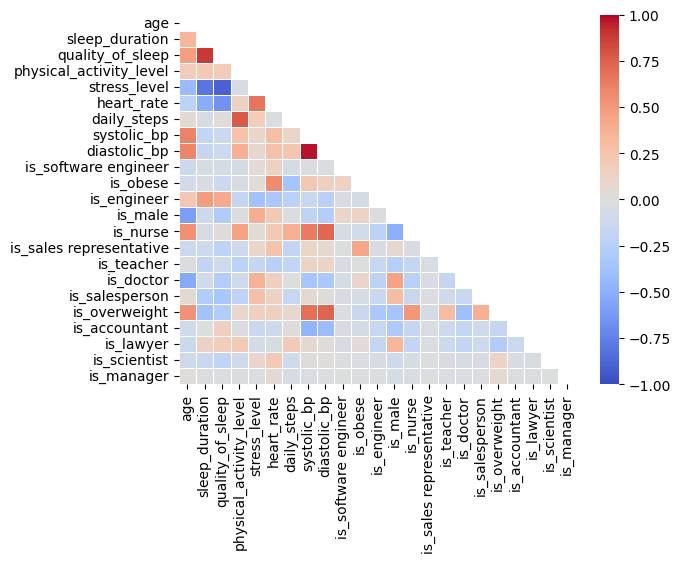

In [200]:
correlation_matrix = df.corr()
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(
    correlation_matrix,
    mask=mask,
    cmap="coolwarm",
    fmt=".2f",
    linewidths=0.5,
    vmin=-1,
    vmax=1
    )

In [ ]:
class CrossVal(BaseEstimator, TransformerMixin):
    def __init__(self, model, cv):
        self.model = model
        self.cv = cv
    def fit(self, X, y):
        accuracy = float(cross_val_score(self.model, X, y, cv=self.cv, scoring='accuracy').mean())
        roc_auc_ovr = float(cross_val_score(self.model, X, y, cv=self.cv, scoring='roc_auc_ovr').mean())
        self.cv_score = {
            'accuracy': accuracy,
            'roc_auc_ovr': roc_auc_ovr
        }
        return self
    

class Selector(BaseEstimator, TransformerMixin):
    def __init__(self, model, no_of_features):
        self.model = model
        self.no_of_features = no_of_features
        self.selector = RFE(estimator=model, n_features_to_select=no_of_features)
    def fit(self, X, y=None):
        self.selector.fit(X, y)
        return self
    def transform(self, X):
        X_out = self.selector.transform(X)
        return X_out
    
def create_pipeline(num_features:int, kfold_split:int=5):
    model = LogisticRegression()
    selector = Selector(model, num_features)
    kf = KFold(n_splits=kfold_split, shuffle=True, random_state=42)
    crs_val = CrossVal(model, kf)

    pipeline = Pipeline([
        ('selector', selector),
        ('cross_validation', crs_val)
    ])

    return pipeline


In [277]:
dic = {}
for i in range(3, len(X.columns)+1):
    pipe = create_pipeline(i).fit(X, y)
    dic[i] = pipe[1].cv_score

In [275]:
dic

{3: {'accuracy': 0.8047207207207208, 'roc_auc_ovr': 0.9066722196370212},
 4: {'accuracy': 0.8742342342342342, 'roc_auc_ovr': 0.9257412691967852},
 5: {'accuracy': 0.8849009009009009, 'roc_auc_ovr': 0.9384042679320791},
 6: {'accuracy': 0.8822342342342342, 'roc_auc_ovr': 0.93496977352128},
 7: {'accuracy': 0.8983423423423422, 'roc_auc_ovr': 0.935893765640115},
 8: {'accuracy': 0.8903423423423424, 'roc_auc_ovr': 0.9344398067449375},
 9: {'accuracy': 0.8903423423423424, 'roc_auc_ovr': 0.9359835112315269},
 10: {'accuracy': 0.8956756756756757, 'roc_auc_ovr': 0.9373324016354851},
 11: {'accuracy': 0.8956756756756757, 'roc_auc_ovr': 0.9305194777386477},
 12: {'accuracy': 0.8876756756756757, 'roc_auc_ovr': 0.9298934021482778},
 13: {'accuracy': 0.8876756756756757, 'roc_auc_ovr': 0.9303562881496596},
 14: {'accuracy': 0.8903423423423422, 'roc_auc_ovr': 0.931254024322649},
 15: {'accuracy': 0.8983423423423422, 'roc_auc_ovr': 0.9283974555307433},
 16: {'accuracy': 0.8956756756756755, 'roc_auc_ov

In [278]:
from typing import Dict, List, Optional, Tuple
import math

MetricsDict = Dict[int, Dict[str, float]]  # {k: {metric_name: value}}

def _metric_names(res: MetricsDict) -> List[str]:
    # union of all metric keys found
    names = set()
    for d in res.values():
        names.update(d.keys())
    return sorted(names)

def _normalize(values: List[float]) -> List[float]:
    vmin, vmax = min(values), max(values)
    if math.isclose(vmin, vmax):
        return [1.0] * len(values)
    return [(v - vmin) / (vmax - vmin) for v in values]

def _prepare(
    res: MetricsDict,
    greater_is_better: Optional[Dict[str, bool]] = None,
):
    """Normalize all metrics to [0,1] and orient so 'higher is better' for all.
    Returns: ks, metrics, norm_oriented: Dict[str, Dict[k, float]]
    """
    ks = sorted(res.keys())
    mnames = _metric_names(res)
    if greater_is_better is None:
        # assume all to be maximized by default
        greater_is_better = {m: True for m in mnames}
    # collect raw per metric
    raw = {m: [res[k][m] for k in ks] for m in mnames}
    # normalize each metric to [0,1]
    norm = {m: _normalize(raw[m]) for m in mnames}
    # orient: if a metric should be minimized, flip it -> 1 - norm
    oriented = {m: (norm[m] if greater_is_better.get(m, True) else [1 - v for v in norm[m]])
                for m in mnames}
    # map back to {metric: {k: val}}
    norm_oriented = {m: {k: oriented[m][i] for i, k in enumerate(ks)} for m in mnames}
    return ks, mnames, norm_oriented, greater_is_better

# ---------------- Strategies ----------------

def pick_lexicographic(
    res: MetricsDict,
    priorities: List[str],
    greater_is_better: Optional[Dict[str, bool]] = None,
) -> int:
    ks, mnames, norm_oriented, _ = _prepare(res, greater_is_better)
    # validate priorities exist
    for p in priorities:
        if p not in mnames:
            raise ValueError(f"Metric '{p}' not found. Available: {mnames}")
    # sort by tuple of oriented normalized metrics (descending naturally)
    return max(ks, key=lambda k: tuple(norm_oriented[m][k] for m in priorities))

def pick_weighted_hmean(
    res: MetricsDict,
    weights: Optional[Dict[str, float]] = None,
    greater_is_better: Optional[Dict[str, bool]] = None,
    eps: float = 1e-12,
) -> int:
    ks, mnames, norm_oriented, _ = _prepare(res, greater_is_better)
    if not weights:
        weights = {m: 1.0 for m in mnames}
    # normalize weights to sum 1
    total_w = sum(weights.get(m, 0.0) for m in mnames)
    if total_w <= 0:
        raise ValueError("Weights must sum to > 0")
    weights = {m: weights.get(m, 0.0) / total_w for m in mnames}

    def hmean_for_k(k):
        # weighted harmonic mean of oriented normalized metrics
        denom = 0.0
        for m in mnames:
            v = max(norm_oriented[m][k], eps)
            denom += weights[m] / v
        return 1.0 / denom

    return max(ks, key=hmean_for_k)

def pareto_front(
    res: MetricsDict,
    greater_is_better: Optional[Dict[str, bool]] = None,
    tol: float = 0.0,
) -> List[int]:
    """Return non-dominated ks. tol >=0 allows near-ties to be considered equal."""
    ks, mnames, norm_oriented, _ = _prepare(res, greater_is_better)

    def dominates(a, b):
        # a dominates b if a >= b in all metrics and > in at least one, within tol
        ge_all = True
        gt_any = False
        for m in mnames:
            va, vb = norm_oriented[m][a], norm_oriented[m][b]
            if va + tol < vb:
                ge_all = False
                break
            if va > vb + tol:
                gt_any = True
        return ge_all and gt_any

    front = []
    for i, ki in enumerate(ks):
        if any(dominates(kj, ki) for kj in ks if kj != ki):
            continue
        front.append(ki)
    return front

def pick_from_pareto_by_distance(
    res: MetricsDict,
    weights: Optional[Dict[str, float]] = None,
    greater_is_better: Optional[Dict[str, bool]] = None,
    tol: float = 0.0,
) -> int:
    """Among Pareto-optimal, choose closest to ideal (all metrics = 1) with optional weights."""
    ks, mnames, norm_oriented, _ = _prepare(res, greater_is_better)
    front = pareto_front(res, greater_is_better, tol)

    if not weights:
        weights = {m: 1.0 for m in mnames}
    total_w = sum(weights.get(m, 0.0) for m in mnames)
    if total_w <= 0:
        raise ValueError("Weights must sum to > 0")
    weights = {m: weights.get(m, 0.0) / total_w for m in mnames}

    def dist2(k):
        # weighted squared distance to (1,...,1) in oriented-normalized space
        s = 0.0
        for m in mnames:
            d = 1.0 - norm_oriented[m][k]
            s += weights[m] * (d * d)
        return s

    return min(front, key=dist2)

# --------------- Example (works with any metric names/count) ---------------


# Use cases:
k_lexi = pick_lexicographic(dic, priorities=["roc_auc_ovr", "accuracy"])
k_hmean = pick_weighted_hmean(dic, weights=None)  # equal weight across all metrics present
k_pareto = pick_from_pareto_by_distance(dic, weights=None, tol=0.0)

print("Lexicographic:", k_lexi)
print("Weighted H-Mean:", k_hmean)
print("Pareto + distance:", k_pareto)


Lexicographic: 5
Weighted H-Mean: 10
Pareto + distance: 10


In [296]:
model = LogisticRegression()
selec = Selector(model, 10)
data = pd.DataFrame(selec.fit_transform(X, y), columns=selec.selector.get_feature_names_out())

In [300]:
model.fit(data, y)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,100
,multi_class,'deprecated'


In [302]:
with open('./../models/model.pkl', 'wb') as file:
    pickle.dump(model, file)

In [295]:
# def hp_tuning_pipeline(num_features:int=10, kfold_split:int=5):
#     model = LogisticRegression()
#     selector = Selector(model, num_features)
#     kf = KFold(n_splits=kfold_split, shuffle=True, random_state=42)
#     crs_val = CrossVal(model, kf)

#     pipeline = Pipeline([
#         ('selector', selector),
#         ('cross_validation', crs_val)
#     ])

#     return pipeline